In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import ticker
import matplotlib.colors as colors
import cmcrameri.cm as cmcm
from scipy.io import readsav
from matplotlib import ticker
import juanfit
from juanfit import SpectrumFitSingle
from eistrick import eis_slit_width_offset
from glob import glob
import pandas as pd
from scipy import interpolate
from matplotlib.patches import Rectangle
import sunpy
import sunpy.map
eit_195_cm = plt.get_cmap("sohoeit195")
from copy import deepcopy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [2]:
eis_save_filenames = glob("../sav/eis_merge/lvl1*")
eis_save_filenames = sorted(eis_save_filenames)
eis_save_filenames

['../sav/eis_merge/lvl1_offset_ech_eis_l1_20070331_113427.sav',
 '../sav/eis_merge/lvl1_offset_ech_eis_l1_20070331_121143.sav',
 '../sav/eis_merge/lvl1_offset_ech_eis_l1_20070331_124913.sav',
 '../sav/eis_merge/lvl1_offset_ech_eis_l1_20070331_132643.sav',
 '../sav/eis_merge/lvl1_offset_ech_eis_l1_20070331_153013.sav',
 '../sav/eis_merge/lvl1_offset_ech_eis_l1_20070331_160743.sav',
 '../sav/eis_merge/lvl1_offset_ech_eis_l1_20070331_164513.sav',
 '../sav/eis_merge/lvl1_offset_ech_eis_l1_20070331_172243.sav',
 '../sav/eis_merge/lvl1_offset_ech_eis_l1_20070331_182413.sav',
 '../sav/eis_merge/lvl1_offset_ech_eis_l1_20070331_190143.sav',
 '../sav/eis_merge/lvl1_offset_ech_eis_l1_20070331_195513.sav',
 '../sav/eis_merge/lvl1_offset_ech_eis_l1_20070331_203243.sav',
 '../sav/eis_merge/lvl1_offset_ech_eis_l1_20070331_213213.sav',
 '../sav/eis_merge/lvl1_offset_ech_eis_l1_20070331_220943.sav',
 '../sav/eis_merge/lvl1_offset_ech_eis_l1_20070331_230743.sav']

In [3]:
eis_saves = []
for filename_ in eis_save_filenames:
    eis_saves.append(readsav(filename_,verbose=False))

In [4]:
eit_195_Aeff_list = pd.read_fwf("../sav/eit_Aeff/eit_195_al1.txt",
                                skiprows=8,names=['wvl','Aeff'],widths=[10,20],encoding='utf-8',index_col=False,
                                dtype = {'':np.float64})

In [5]:
eis_img_combine_corp = np.zeros((119,490,4096))
eis_err_combine_corp = np.zeros((119,490,4096))
for ii, eis_save in enumerate(eis_saves):
    if ii < 4:
        eis_img_combine_corp[119-7*(ii+1):119-7*ii,:,:] = np.flip(eis_save["new_data_offset"][:,22:512,:],axis=0)
        eis_err_combine_corp[119-7*(ii+1):119-7*ii,:,:] = np.flip(eis_save["new_err_offset"][:,22:512,:],axis=0)
    else:
        eis_img_combine_corp[119-7*(ii+3):119-7*(ii+2),:,:] = np.flip(eis_save["new_data_offset"][:,22:512,:],axis=0)
        eis_err_combine_corp[119-7*(ii+3):119-7*(ii+2),:,:] = np.flip(eis_save["new_err_offset"][:,22:512,:],axis=0)


495.71964 -155.59515
488.57016 -155.8103
481.2479 -156.09747
474.19537 -156.19489
450.45 -156.9472
443.47577 -157.14154
436.28598 -157.4107
428.1377 -157.52399
416.2271 -158.05212
409.07724 -158.30206
398.34946 -158.53052
391.21982 -158.89868
379.59424 -159.2074
372.40036 -159.52563
360.7397 -159.75061


(-500.0, 200.0)

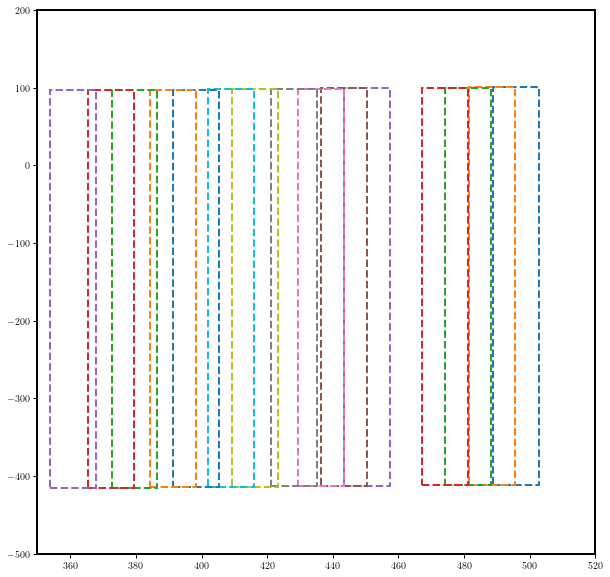

In [6]:
prop_cycle = rcParams['axes.prop_cycle']
colors_cycle = prop_cycle.by_key()['color']
len_colors = len(colors_cycle)
fig, ax = plt.subplots(figsize=(10,10))
for ii, eis_save in enumerate(eis_saves):
    eis_xcen = eis_save["xcen"]
    eis_ycen = eis_save["ycen"]
    eis_fovx = eis_save["fovx"]
    eis_fovy = eis_save["fovy"]

    print(eis_xcen,eis_ycen)

    x0= eis_xcen- eis_fovx/2
    x1= eis_xcen+ eis_fovx/2
    y0= eis_ycen- eis_fovy/2
    y1= eis_ycen+ eis_fovy/2
    fov_rec = Rectangle((x0, y0), eis_fovx, eis_fovy, ls="--", lw=2, ec=colors_cycle[ii%len_colors], fc="none")

    ax.add_patch(fov_rec)

ax.set_xlim(350,520)
ax.set_ylim(-500,200)

    

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


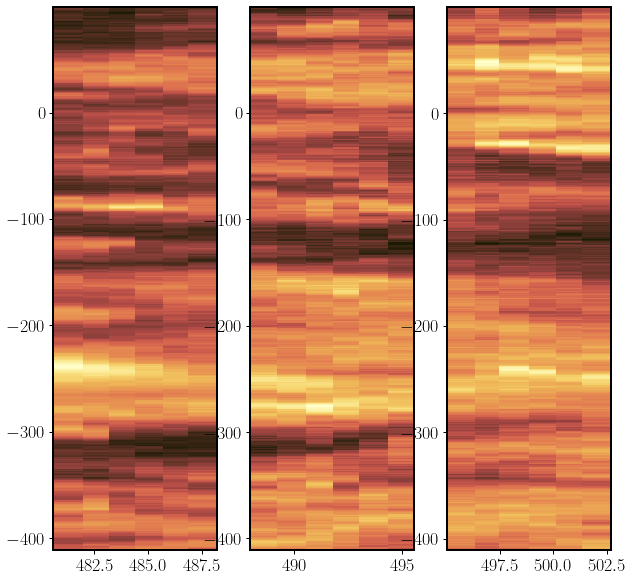

In [7]:
fig, axes = plt.subplots(1,3,figsize=(10,10))
FeVIII_185_slice = (835,855)
FeVIII_186_slice = (900,913)
for ii, eis_save in enumerate(eis_saves[:3]):
    eis_data = eis_save["new_data_offset"]
    eis_err = eis_save["new_err_offset"]
    eis_wvl = eis_save["wvl"]
    eis_xcoord = eis_save["xpos"]
    eis_ycoord = eis_save["ypos"]
    FeVIII_185_int_map = np.sum(eis_data[:,2:514,FeVIII_185_slice[0]:FeVIII_185_slice[1]],axis=2)
    FeVIII_186_int_map = np.sum(eis_data[:,2:514,FeVIII_186_slice[0]:FeVIII_186_slice[1]],axis=2)

    axes[2-ii].pcolormesh(eis_xcoord,eis_ycoord,np.log10(FeVIII_185_int_map.T),cmap=cmcm.lajolla_r)
    axes[2-ii].tick_params(labelsize=18)
   # ax.axis("scaled")


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]


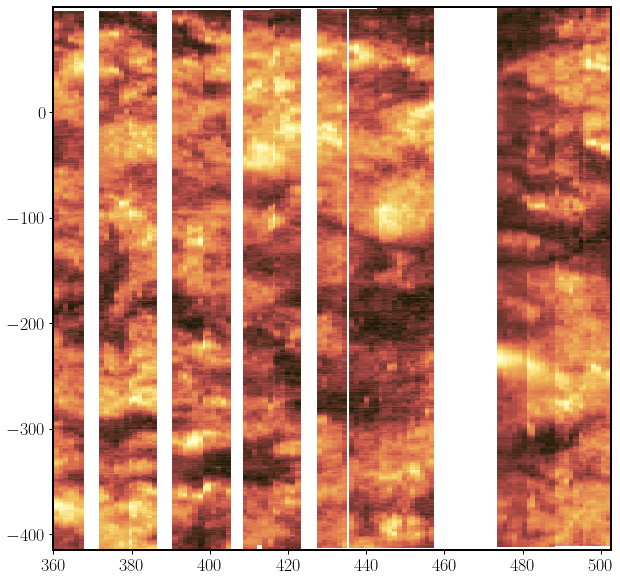

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
FeVIII_185_slice = (835,855)
FeVIII_186_slice = (900,913)
for ii, eis_save in enumerate(eis_saves):
    eis_data = eis_save["new_data_offset"]
    eis_err = eis_save["new_err_offset"]
    eis_wvl = eis_save["wvl"]
    eis_xcoord = eis_save["xpos"]
    eis_ycoord = eis_save["ypos"]
    FeVIII_185_int_map = np.sum(eis_data[:,2:514,FeVIII_185_slice[0]:FeVIII_185_slice[1]],axis=2)
    FeVIII_186_int_map = np.sum(eis_data[:,2:514,FeVIII_186_slice[0]:FeVIII_186_slice[1]],axis=2)

    ax.pcolormesh(eis_xcoord,eis_ycoord,np.log10(FeVIII_185_int_map.T),cmap=cmcm.lajolla_r)
    ax.tick_params(labelsize=18)
   # ax.axis("scaled")


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


(259.7, 495.7, -392.5, 96.5)

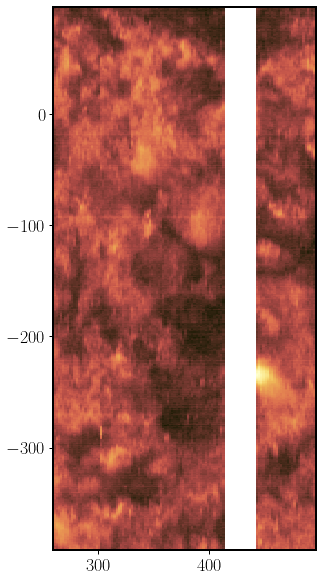

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
xcoord_comb = np.linspace(495.7-236,495.7, 119)
ycoord_comb = np.linspace( -157 - 235.5, -157 -235.5 + 489, 490)
FeVIII_185_combine_map = np.sum(eis_img_combine_corp[:,:,FeVIII_185_slice[0]:FeVIII_185_slice[1]],axis=2)
ax.pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeVIII_185_combine_map.T),cmap=cmcm.lajolla_r)
ax.tick_params(labelsize=18)
ax.axis("scaled")


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


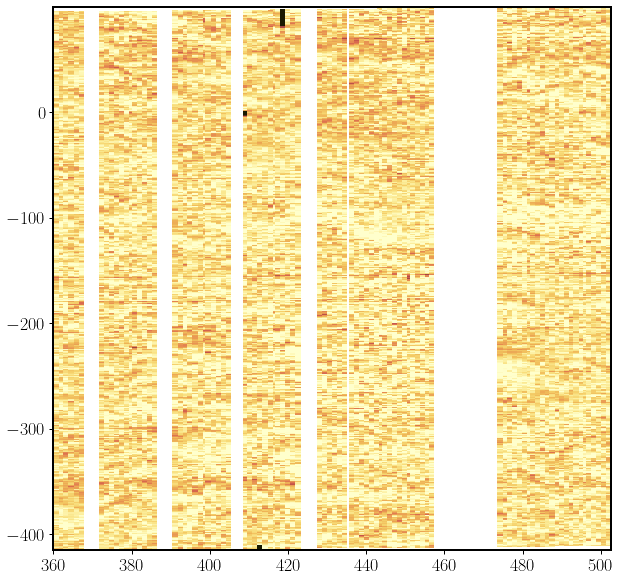

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
for ii, eis_save in enumerate(eis_saves):
    eis_data = eis_save["new_data_offset"]
    eis_err = eis_save["new_err_offset"]
    eis_wvl = eis_save["wvl"]
    eis_xcoord = eis_save["xpos"]
    eis_ycoord = eis_save["ypos"]
    FeVIII_185_int_map = np.sum(eis_data[:,2:514,FeVIII_185_slice[0]:FeVIII_185_slice[1]],axis=2)
    FeVIII_186_int_map = np.sum(eis_data[:,2:514,FeVIII_186_slice[0]:FeVIII_186_slice[1]],axis=2)

    ax.pcolormesh(eis_xcoord,eis_ycoord,FeVIII_185_int_map.T/FeVIII_186_int_map.T,cmap=cmcm.lajolla_r,vmin=0.7,vmax=1.5)
    ax.tick_params(labelsize=18)

In [11]:
ratio_data = pd.read_fwf('../chianti_ratio/den_186_185_ph.txt',skiprows=6,names=['ne','ratio'],widths=[10,10],encoding='utf-8',index_col=False,skipfooter=3)
f_185_186 = interpolate.interp1d(1./ratio_data['ratio'].values,ratio_data['ne'].values,fill_value="extrapolate")

/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


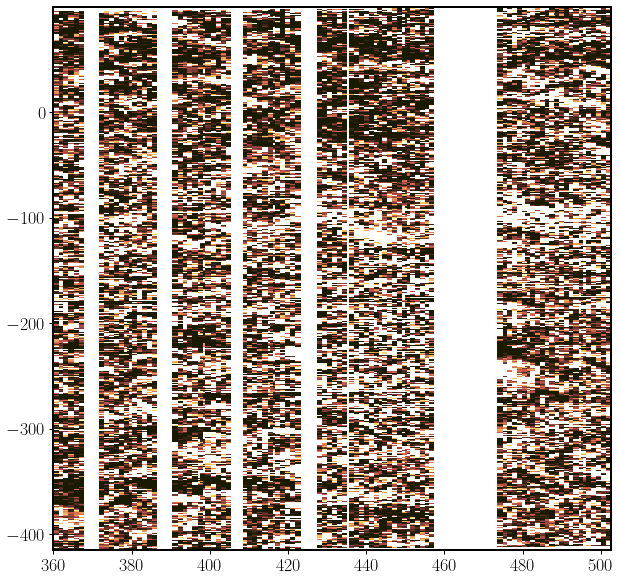

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
for ii, eis_save in enumerate(eis_saves):
    eis_data = eis_save["new_data_offset"]
    eis_err = eis_save["new_err_offset"]
    eis_wvl = eis_save["wvl"]
    eis_xcoord = eis_save["xpos"]
    eis_ycoord = eis_save["ypos"]
    FeVIII_185_int_map = np.sum(eis_data[:,2:514,FeVIII_185_slice[0]:FeVIII_185_slice[1]],axis=2)
    FeVIII_186_int_map = np.sum(eis_data[:,2:514,FeVIII_186_slice[0]:FeVIII_186_slice[1]],axis=2)

    ax.pcolormesh(eis_xcoord,eis_ycoord,f_185_186(FeVIII_185_int_map.T/FeVIII_186_int_map.T),cmap=cmcm.lajolla_r,vmin=8,vmax=9)
    ax.tick_params(labelsize=18)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':


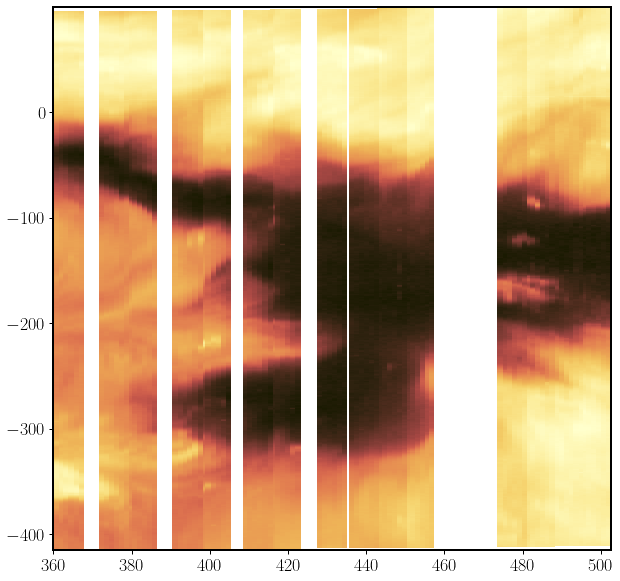

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
FeXII_195_slice = (1283,1300)
FeXII_186_slice = (914,930)
for ii, eis_save in enumerate(eis_saves):
    eis_data = eis_save["new_data_offset"]
    eis_err = eis_save["new_err_offset"]
    eis_wvl = eis_save["wvl"]
    eis_xcoord = eis_save["xpos"]
    eis_ycoord = eis_save["ypos"]
    FeXII_195_int_map = np.sum(eis_data[:,2:514,FeXII_195_slice[0]:FeXII_195_slice[1]],axis=2)

    ax.pcolormesh(eis_xcoord,eis_ycoord,np.log10(FeXII_195_int_map.T),cmap=cmcm.lajolla_r)
    ax.tick_params(labelsize=18)
    #ax.axis("scaled")


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


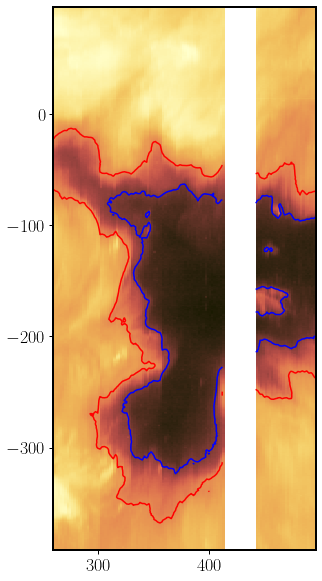

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
FeXII_195_combine_map = np.sum(eis_img_combine_corp[:,:,FeXII_195_slice[0]:FeXII_195_slice[1]],axis=2)
ax.pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeXII_195_combine_map.T),cmap=cmcm.lajolla_r)
ax.tick_params(labelsize=18)
ax.axis("scaled")
ax.contour(xcoord_comb, ycoord_comb,np.log10(FeXII_195_combine_map.T),
                levels=[np.log10(6000)],colors='red')
ax.contour(xcoord_comb, ycoord_comb,np.log10(FeXII_195_combine_map.T),
                levels=[np.log10(2000)],colors='blue')
FeXII_195_combine_rebin = np.average(FeXII_195_combine_map[1:,2:].reshape(59,2,122,4),axis=(1,3))
qs_index = np.where(FeXII_195_combine_rebin >= 6000)
ch_index = np.where( (FeXII_195_combine_rebin < 6000) & (FeXII_195_combine_rebin > 0))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


(259.7, 495.7, -392.5, 96.5)

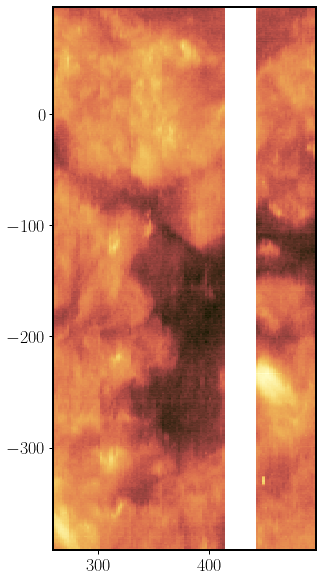

In [15]:
FeIX_197_slice = (1400,1422)
fig, ax = plt.subplots(figsize=(10,10))
FeIX_197_combine_map = np.sum(eis_img_combine_corp[:,:,FeIX_197_slice[0]:FeIX_197_slice[1]],axis=2)
FeIX_197_combine_rebin = np.sum(FeIX_197_combine_map[1:,2:].reshape(59,2,122,4),axis=(1,3))*1.16
ax.pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeIX_197_combine_map.T),cmap=cmcm.lajolla_r)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


(259.7, 495.7, -392.5, 96.5)

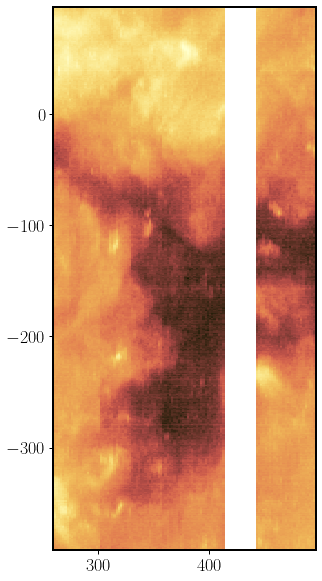

In [16]:
FeIX_191_slice = (1110,1125)
fig, ax = plt.subplots(figsize=(10,10))
FeIX_191_combine_map = np.sum(eis_img_combine_corp[:,:,FeIX_191_slice[0]:FeIX_191_slice[1]],axis=2)
FeIX_191_combine_rebin = np.sum(FeIX_191_combine_map[1:,2:].reshape(59,2,122,4),axis=(1,3))*1.19
ax.pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeIX_191_combine_map.T),cmap=cmcm.lajolla_r)
ax.tick_params(labelsize=18)
ax.axis("scaled")


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


(259.7, 495.7, -392.5, 96.5)

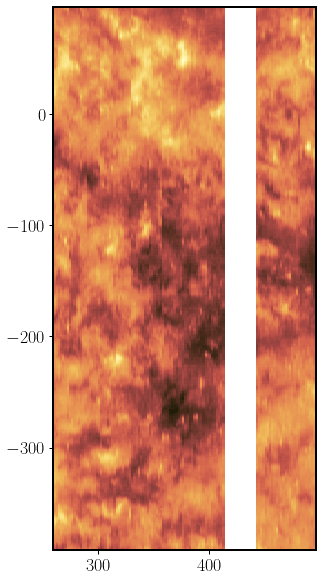

In [17]:
HeII_256_slice = (2500,2532)
fig, ax = plt.subplots(figsize=(10,10))
HeII_256_combine_map = np.sum(eis_img_combine_corp[:,:,HeII_256_slice[0]:HeII_256_slice[1]],axis=2)
ax.pcolormesh(xcoord_comb, ycoord_comb, np.log10(HeII_256_combine_map.T),cmap=cmcm.lajolla_r)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


(259.7, 495.7, -392.5, 96.5)

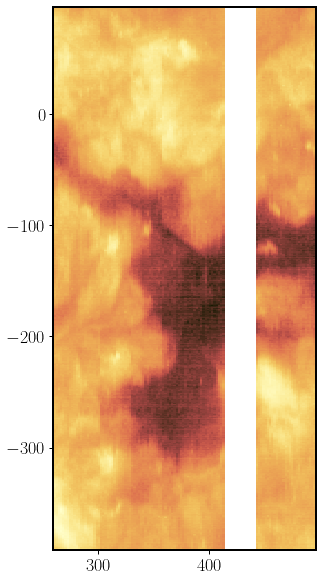

In [18]:
FeX_257_slice = (2550,2568)
fig, ax = plt.subplots(figsize=(10,10))
FeX_257_combine_map = np.sum(eis_img_combine_corp[:,:,FeX_257_slice[0]:FeX_257_slice[1]],axis=2)
FeX_257_combine_rebin = np.sum(FeX_257_combine_map[1:,2:].reshape(59,2,122,4),axis=(1,3))*1.44
ax.pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeX_257_combine_map.T),cmap=cmcm.lajolla_r)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


(259.7, 495.7, -392.5, 96.5)

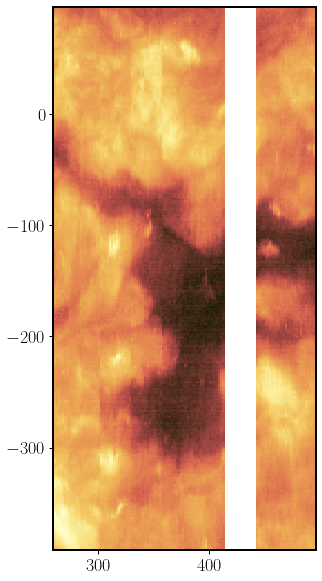

In [19]:
FeX_184_slice = (810,822)
fig, ax = plt.subplots(figsize=(10,10))
FeX_184_combine_map = np.sum(eis_img_combine_corp[:,:,FeX_184_slice[0]:FeX_184_slice[1]],axis=2)
FeX_184_combine_rebin = np.sum(FeX_184_combine_map[1:,2:].reshape(59,2,122,4),axis=(1,3))*1.35
ax.pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeX_184_combine_map.T),cmap=cmcm.lajolla_r)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


(259.7, 495.7, -392.5, 96.5)

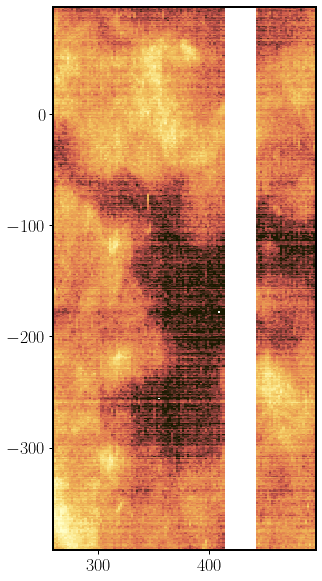

In [20]:
FeX_174_slice = (360,375)
fig, ax = plt.subplots(figsize=(10,10))
FeX_174_combine_map = np.sum(eis_img_combine_corp[:,:,FeX_174_slice[0]:FeX_174_slice[1]],axis=2)
FeX_174_combine_rebin = np.sum(FeX_174_combine_map[1:,2:].reshape(59,2,122,4),axis=(1,3))*1.7
ax.pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeX_174_combine_map.T),cmap=cmcm.lajolla_r,vmin=3.5)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


(259.7, 495.7, -392.5, 96.5)

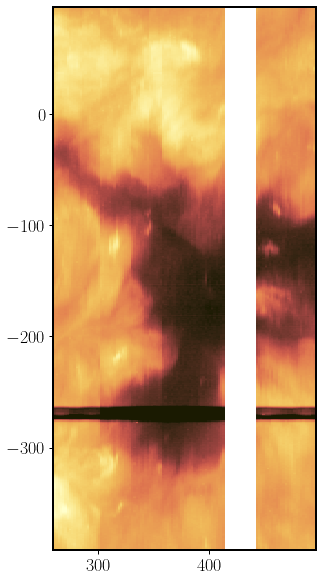

In [21]:
FeXI_188_slice = (970,990)
fig, ax = plt.subplots(figsize=(10,10))
FeXI_188_combine_map = np.sum(eis_img_combine_corp[:,:,FeXI_188_slice[0]:FeXI_188_slice[1]],axis=2)
ax.pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeXI_188_combine_map.T),cmap=cmcm.lajolla_r,vmin=3)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


(259.7, 495.7, -392.5, 96.5)

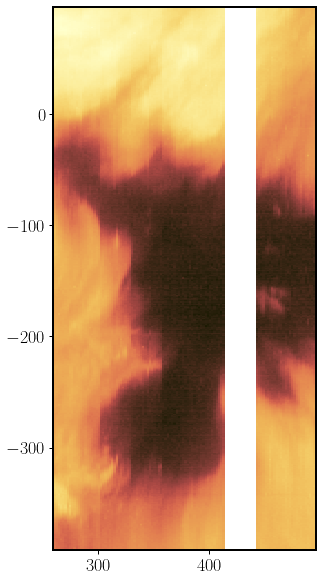

In [22]:
FeXIII_202_slice = (1594,1610)
fig, ax = plt.subplots(figsize=(10,10))
FeXIII_202_combine_map = np.sum(eis_img_combine_corp[:,:,FeXIII_202_slice[0]:FeXIII_202_slice[1]],axis=2)
ax.pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeXIII_202_combine_map.T),cmap=cmcm.lajolla_r)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


(259.7, 495.7, -392.5, 96.5)

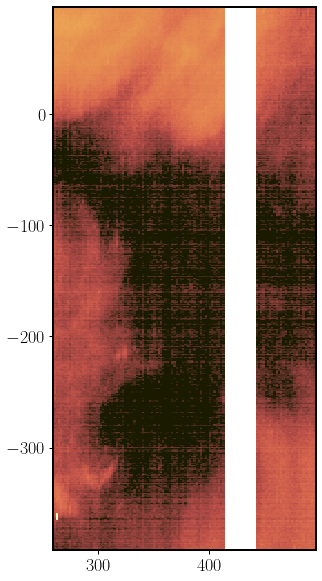

In [23]:
FeXIV_211_slice = (2000,2035)
fig, ax = plt.subplots(figsize=(10,10))
FeXIV_211_combine_map = np.sum(eis_img_combine_corp[:,:,FeXIV_211_slice[0]:FeXIV_211_slice[1]],axis=2)
FeXIV_211_combine_map[FeXIV_211_combine_map < 0] = 1
ax.pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeXIV_211_combine_map.T),cmap=cmcm.lajolla_r,vmin=2.4)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


(259.7, 495.7, -392.5, 96.5)

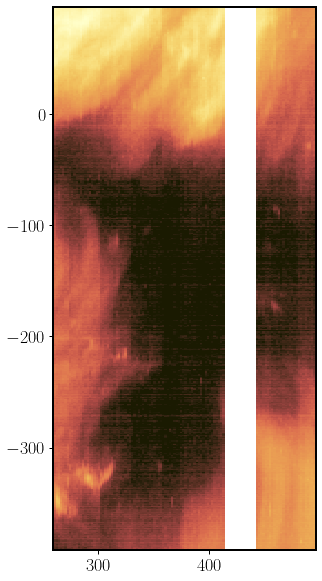

In [24]:
FeXV_284_slice = (3760,3780)
fig, ax = plt.subplots(figsize=(10,10))
FeXV_284_combine_map = np.sum(eis_img_combine_corp[:,:,FeXV_284_slice[0]:FeXV_284_slice[1]],axis=2)
ax.pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeXV_284_combine_map.T),cmap=cmcm.lajolla_r,vmin=2.5)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


(259.7, 495.7, -392.5, 96.5)

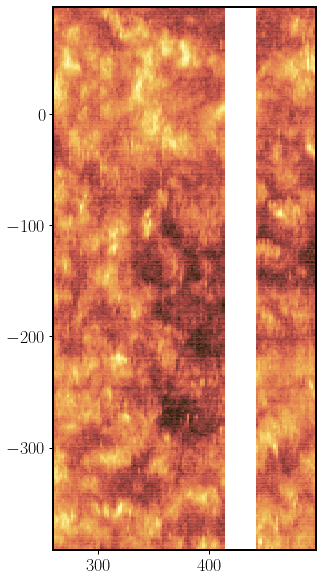

In [25]:
OVI_184_slice = (791,803)
fig, ax = plt.subplots(figsize=(10,10))
OVI_184_combine_map = np.sum(eis_img_combine_corp[:,:,OVI_184_slice[0]:OVI_184_slice[1]],axis=2)
ax.pcolormesh(xcoord_comb, ycoord_comb, np.log10(OVI_184_combine_map.T),cmap=cmcm.lajolla_r)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero 

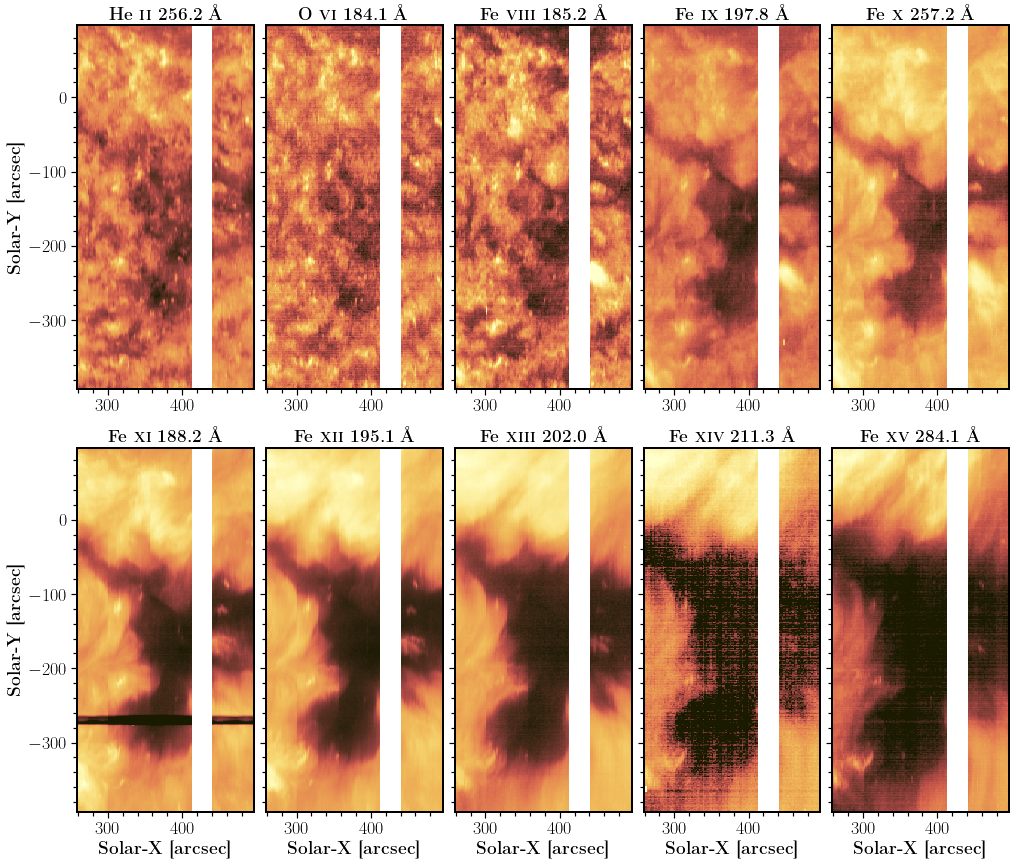

In [56]:
fig, axes = plt.subplots(2,5,figsize=(14,12),constrained_layout=True)

axes[0,0].pcolormesh(xcoord_comb, ycoord_comb, np.log10(HeII_256_combine_map.T),cmap=cmcm.lajolla_r,
shading="auto",rasterized=True)
axes[0,1].pcolormesh(xcoord_comb, ycoord_comb, np.log10(OVI_184_combine_map.T),cmap=cmcm.lajolla_r,
shading="auto",rasterized=True)
axes[0,2].pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeVIII_185_combine_map.T),cmap=cmcm.lajolla_r,
vmax = np.log10(np.nanpercentile(FeVIII_185_combine_map,99.7)),shading="auto",rasterized=True)
axes[0,3].pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeIX_197_combine_map.T),cmap=cmcm.lajolla_r,
shading="auto",rasterized=True)
axes[0,4].pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeX_257_combine_map.T),cmap=cmcm.lajolla_r,
shading="auto",rasterized=True)
axes[1,0].pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeXI_188_combine_map.T),cmap=cmcm.lajolla_r,vmin=3,
shading="auto",rasterized=True)
axes[1,1].pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeXII_195_combine_map.T),cmap=cmcm.lajolla_r,
shading="auto",rasterized=True)
axes[1,2].pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeXIII_202_combine_map.T),cmap=cmcm.lajolla_r,
shading="auto",rasterized=True)
axes[1,3].pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeXIV_211_combine_map.T),cmap=cmcm.lajolla_r,vmin=2.4,vmax=4.2,
shading="auto",rasterized=True)
axes[1,4].pcolormesh(xcoord_comb, ycoord_comb, np.log10(FeXV_284_combine_map.T),cmap=cmcm.lajolla_r,vmin=2.5,
shading="auto",rasterized=True)

titles = [r"\textbf{He \textsc{ii} 256.2 \mbox{\AA}}",r"\textbf{O \textsc{vi} 184.1 \mbox{\AA}}",
            r"\textbf{Fe \textsc{viii} 185.2 \mbox{\AA}}",r"\textbf{Fe \textsc{ix} 197.8 \mbox{\AA}}",
            r"\textbf{Fe \textsc{x} 257.2 \mbox{\AA}}",r"\textbf{Fe \textsc{xi} 188.2 \mbox{\AA}}",
            r"\textbf{Fe \textsc{xii} 195.1 \mbox{\AA}}",r"\textbf{Fe \textsc{xiii} 202.0 \mbox{\AA}}",
            r"\textbf{Fe \textsc{xiv} 211.3 \mbox{\AA}}",r"\textbf{Fe \textsc{xv} 284.1 \mbox{\AA}}"]
Tmaxs = [r"$\log T_{\rm max} \sim 4.9$",r"$\log T_{\rm max} \sim 4.9$",r"$\log T_{\rm max} \sim 4.9$",
        r"$\log T_{\rm max} \sim 4.9$",r"$\log T_{\rm max} \sim 4.9$",r"$\log T_{\rm max} \sim 4.9$",
        r"$\log T_{\rm max} \sim 4.9$",r"$\log T_{\rm max} \sim 4.9$",r"$\log T_{\rm max} \sim 4.9$",
        r"$\log T_{\rm max} \sim 4.9$"]

for ii, ax_ in enumerate(axes.flatten()):
    if (ii != 0) and (ii != 5):
        ax_.yaxis.set_ticklabels([])
    if (ii == 0) or (ii == 5):
        ax_.set_ylabel(r"\textbf{Solar-Y [arcsec]}",fontsize=18)
    if (ii >= 5):
        ax_.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=18)

        
    ax_.set_title(titles[ii],fontsize=18)
    ax_.tick_params(labelsize=18)
    ax_.axis("scaled")
    #ax_.text(0.02,0.99,Tmaxs[ii],fontsize=18,color="white",va="top",ha="left",transform=ax_.transAxes)
    ax_.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax_.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax_.tick_params(which="major",width=1.2,length=6)
    ax_.tick_params(which="minor",width=1.2,length=4)
    
plt.savefig(fname="../figs/eis_summary.pdf",format="pdf",transparent=False)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


(262.7, 494.7, -389.0, 95.0)

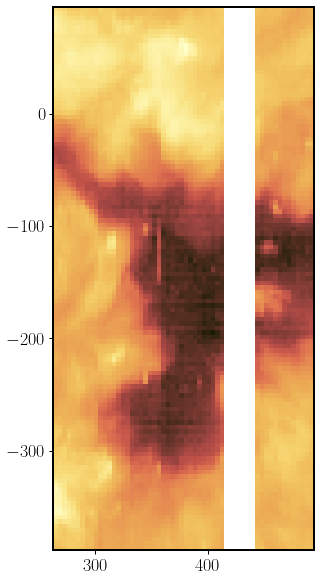

In [27]:
SiX_258_slice = (2600,2620)
fig, ax = plt.subplots(figsize=(10,10))
SiX_258_combine_map = np.sum(eis_img_combine_corp[:,:,SiX_258_slice[0]:SiX_258_slice[1]],axis=2)*1.39
SiX_258_combine_rebin = np.sum(SiX_258_combine_map[1:,2:].reshape(59,2,122,4),axis=(1,3))
xcoord_comb_rebin = np.average(xcoord_comb[1:].reshape(59,2),axis=1)
ycoord_comb_rebin = np.average(ycoord_comb[2:].reshape(122,4),axis=1)
#ax.pcolormesh(xcoord_comb, ycoord_comb, np.log10(SiX_258_combine_map.T),cmap=cmcm.lajolla_r,vmin=2)
ax.pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, np.log10(SiX_258_combine_rebin.T),cmap=cmcm.lajolla_r,vmin=3)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


(262.7, 494.7, -389.0, 95.0)

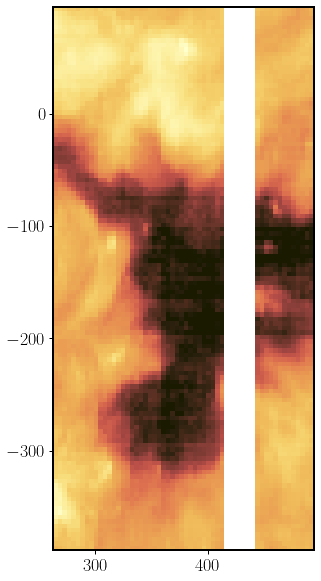

In [28]:
SiX_261_slice = (2720,2738)
fig, ax = plt.subplots(figsize=(10,10))
SiX_261_combine_map = np.sum(eis_img_combine_corp[:,:,SiX_261_slice[0]:SiX_261_slice[1]],axis=2)*1.32674
SiX_261_combine_rebin = np.sum(SiX_261_combine_map[1:,2:].reshape(59,2,122,4),axis=(1,3))
xcoord_comb_rebin = np.average(xcoord_comb[1:].reshape(59,2),axis=1)
ycoord_comb_rebin = np.average(ycoord_comb[2:].reshape(122,4),axis=1)
#ax.pcolormesh(xcoord_comb, ycoord_comb, np.log10(SiX_261_combine_map.T),cmap=cmcm.lajolla_r,vmin=2)
ax.pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, np.log10(SiX_261_combine_rebin.T),cmap=cmcm.lajolla_r,vmin=3)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


(262.7, 494.7, -389.0, 95.0)

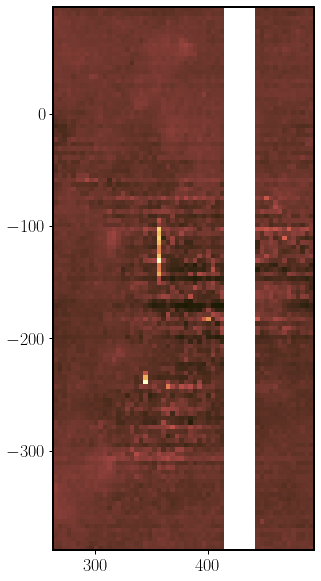

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ax.pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, (SiX_258_combine_rebin/SiX_261_combine_rebin).T,cmap=cmcm.lajolla_r)
ax.tick_params(labelsize=18)
ax.axis("scaled")

In [30]:
ratio_data_SiX_258_261 = pd.read_csv('../chianti_ratio/den_SiX_258_261.txt',skiprows=6,names=['ne','ratio'],sep="\s+",index_col=False,dtype=np.float64)
f_SiX_258_261 = interpolate.interp1d(ratio_data_SiX_258_261['ratio'].values,ratio_data_SiX_258_261['ne'].values,fill_value="extrapolate")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


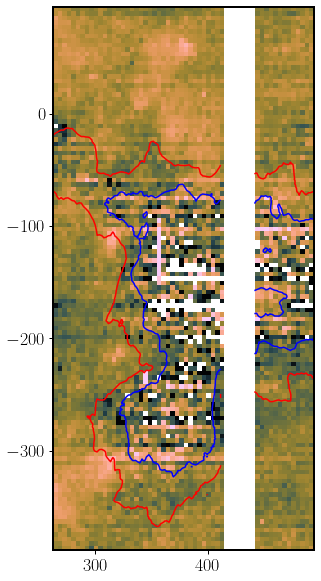

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
ax.pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, f_SiX_258_261((SiX_258_combine_rebin/SiX_261_combine_rebin).T),cmap=cmcm.batlowK,vmin=7.5,vmax=9)
ax.tick_params(labelsize=18)
ax.axis("scaled")
ax.contour(xcoord_comb, ycoord_comb,np.log10(FeXII_195_combine_map.T),
                levels=[np.log10(6000)],colors='red')
ax.contour(xcoord_comb, ycoord_comb,np.log10(FeXII_195_combine_map.T),
                levels=[np.log10(2000)],colors='blue')


In [32]:
SiX_258_combine_rebin_2 = np.copy(SiX_258_combine_rebin)
SiX_258_combine_rebin_10 = np.copy(SiX_258_combine_rebin)
SiX_258_combine_rebin_2[ch_index] = SiX_258_combine_rebin_2[ch_index] - np.average(SiX_258_combine_rebin[qs_index])*0.02
SiX_258_combine_rebin_10[ch_index] = SiX_258_combine_rebin_10[ch_index] - np.average(SiX_258_combine_rebin[qs_index])*0.1
SiX_261_combine_rebin_2 = np.copy(SiX_261_combine_rebin)
SiX_261_combine_rebin_10 = np.copy(SiX_261_combine_rebin)
SiX_261_combine_rebin_2[ch_index] = SiX_261_combine_rebin_2[ch_index] - np.average(SiX_261_combine_rebin[qs_index])*0.02
SiX_261_combine_rebin_10[ch_index] = SiX_261_combine_rebin_10[ch_index] - np.average(SiX_261_combine_rebin[qs_index])*0.1


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


(262.7, 494.7, -389.0, 95.0)

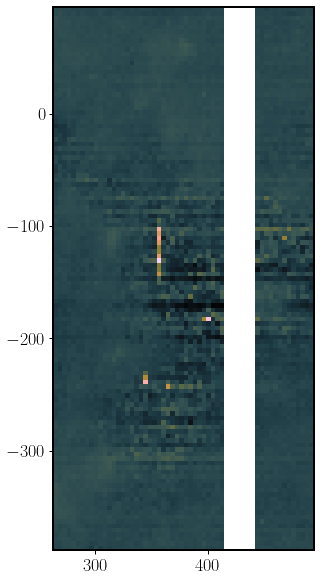

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax.pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, (SiX_258_combine_rebin_2/SiX_261_combine_rebin_2).T,cmap=cmcm.batlowK)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


(262.7, 494.7, -389.0, 95.0)

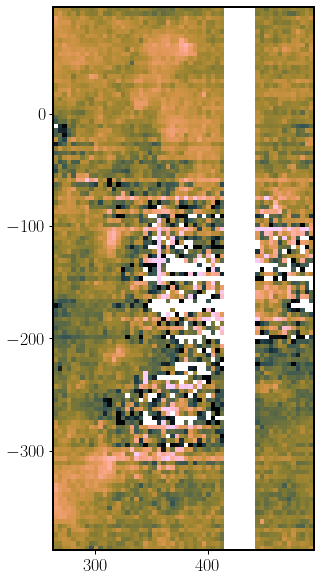

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
ax.pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, f_SiX_258_261((SiX_258_combine_rebin_2/SiX_261_combine_rebin_2).T),cmap=cmcm.batlowK,vmin=7.5,vmax=9)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


(262.7, 494.7, -389.0, 95.0)

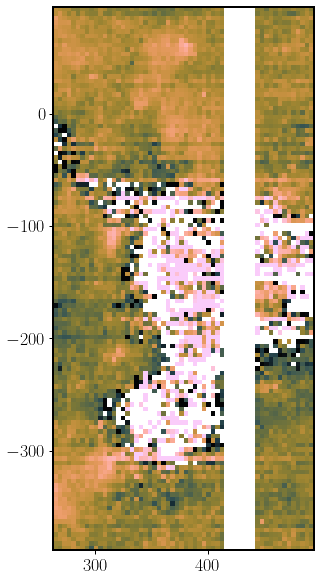

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
ax.pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, f_SiX_258_261((SiX_258_combine_rebin_10/SiX_261_combine_rebin_10).T),cmap=cmcm.batlowK,vmin=7.5,vmax=9)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


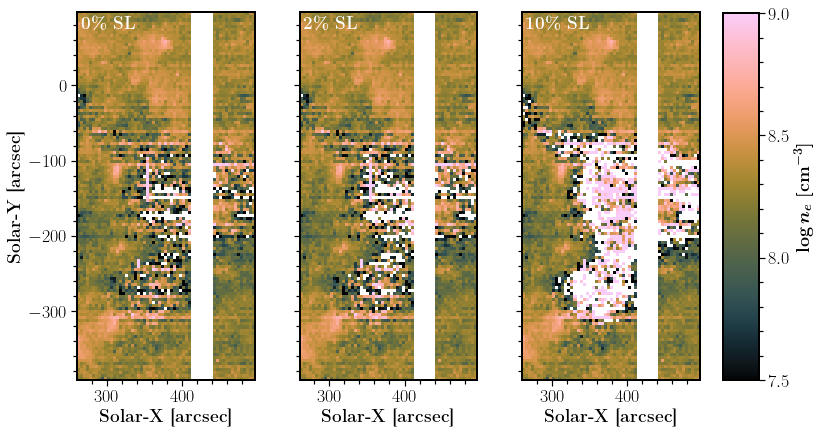

In [90]:
fig, axes = plt.subplots(1,3,figsize=(12,6))
im0 = axes[0].pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, 
f_SiX_258_261((SiX_258_combine_rebin/SiX_261_combine_rebin).T),
cmap=cmcm.batlowK,vmin=7.5,vmax=9,shading="auto",rasterized=True)
im1 = axes[1].pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, 
f_SiX_258_261((SiX_258_combine_rebin_2/SiX_261_combine_rebin_2).T),
cmap=cmcm.batlowK,vmin=7.5,vmax=9,shading="auto",rasterized=True)
im2 = axes[2].pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, 
f_SiX_258_261((SiX_258_combine_rebin_10/SiX_261_combine_rebin_10).T),
cmap=cmcm.batlowK,vmin=7.5,vmax=9,shading="auto",rasterized=True)

titles = [r"\textbf{0\% SL}",r"\textbf{2\% SL}",r"\textbf{10\% SL}"]
imgs = [im0,im1,im2]
for ii, ax_ in enumerate(axes):
    if (ii != 0):
        ax_.yaxis.set_ticklabels([])
    if (ii == 0):
        ax_.set_ylabel(r"\textbf{Solar-Y [arcsec]}",fontsize=18)

    #plt.colorbar(imgs[ii],ax=ax_,location="top",fraction=0.7)   
    ax_.axis("scaled")
    ax_.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax_.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax_.tick_params(which="major",width=1.2,length=6)
    ax_.tick_params(which="minor",width=1.2,length=4)
    ax_.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=18)       
    ax_.text(0.02,0.99,titles[ii],fontsize=18,color="white",transform=ax_.transAxes,ha="left",va="top")       
    ax_.tick_params(labelsize=18)

clb_ax = inset_axes(axes[2],width="20%",height= "100%",
                bbox_to_anchor=(0.5, 0.08, 1, 1),
                bbox_transform=axes[2].transAxes,
                borderpad=3)
clb = plt.colorbar(imgs[ii],pad = 0.05,orientation='vertical',ax=axes[2],cax=clb_ax)
clb_ax.yaxis.get_offset_text().set_fontsize(15)
clb_ax.yaxis.set_major_locator(ticker.MaxNLocator(3)) 
clb_ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5)) 
clb_ax.tick_params(which="major",width=1.2,length=6)
clb_ax.tick_params(which="minor",width=1.2,length=4)
# clb_ax.yaxis.tick_right()
clb_ax.tick_params(labelsize=18)
# clb_ax.xaxis.set_label_position('top') 
clb_ax.set_ylabel(r"$\boldsymbol{\log n_e\ \mathrm{[cm^{-3}]}}$",fontsize=18)

plt.subplots_adjust(bottom = 0.12,left=0.12,top=0.97,right=0.85)
plt.savefig(fname="../figs/dens_SiX.pdf",format="pdf")


In [37]:
ratio_data_FeX_184_257 = pd.read_csv('../chianti_ratio/temp_FeX_184_257.txt',skiprows=6,names=['Te','ratio'],sep="\s+",index_col=False,dtype=np.float64)
f_FeX_184_257 = interpolate.interp1d(ratio_data_FeX_184_257['ratio'].values,ratio_data_FeX_184_257['Te'].values,fill_value="extrapolate")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


(262.7, 494.7, -389.0, 95.0)

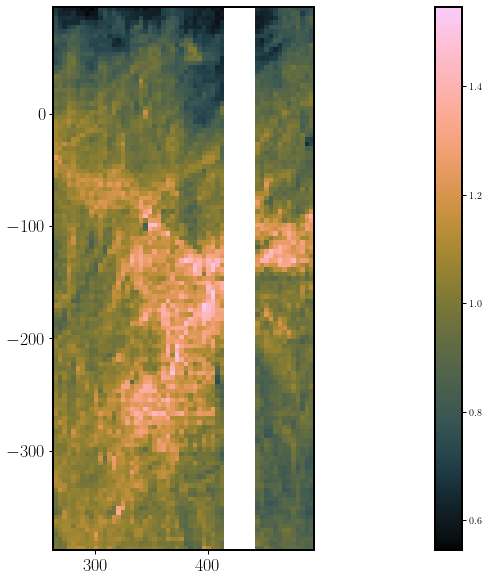

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, (FeX_184_combine_rebin/FeX_257_combine_rebin).T,cmap=cmcm.batlowK)
plt.colorbar(im)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


(262.7, 494.7, -389.0, 95.0)

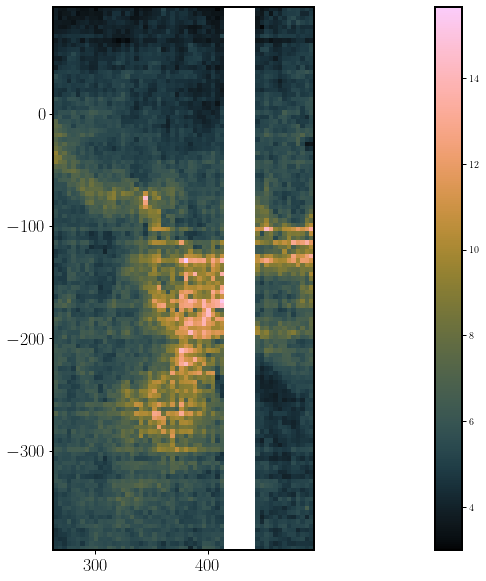

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, (FeX_174_combine_rebin/FeX_257_combine_rebin).T,cmap=cmcm.batlowK)
plt.colorbar(im)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


(262.7, 494.7, -389.0, 95.0)

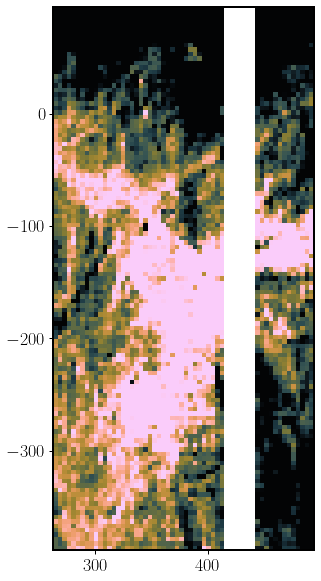

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
ax.pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, f_FeX_184_257((FeX_184_combine_rebin/FeX_257_combine_rebin).T),cmap=cmcm.batlowK,vmin=5.9,vmax=6.1)
ax.tick_params(labelsize=18)
ax.axis("scaled")

In [41]:
FeX_184_combine_rebin_2 = np.copy(FeX_184_combine_rebin)
FeX_184_combine_rebin_10 = np.copy(FeX_184_combine_rebin)
FeX_184_combine_rebin_2[ch_index] = FeX_184_combine_rebin_2[ch_index] - np.average(FeX_184_combine_rebin[qs_index])*0.02
FeX_184_combine_rebin_10[ch_index] = FeX_184_combine_rebin_10[ch_index] - np.average(FeX_184_combine_rebin[qs_index])*0.1
FeX_257_combine_rebin_2 = np.copy(FeX_257_combine_rebin)
FeX_257_combine_rebin_10 = np.copy(FeX_257_combine_rebin)
FeX_257_combine_rebin_2[ch_index] = FeX_257_combine_rebin_2[ch_index] - np.average(FeX_257_combine_rebin[qs_index])*0.02
FeX_257_combine_rebin_10[ch_index] = FeX_257_combine_rebin_10[ch_index] - np.average(FeX_257_combine_rebin[qs_index])*0.1


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


(262.7, 494.7, -389.0, 95.0)

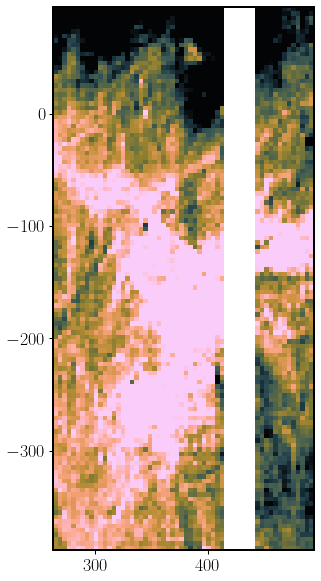

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
ax.pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, f_FeX_184_257((FeX_184_combine_rebin_2/FeX_257_combine_rebin_2).T),cmap=cmcm.batlowK,vmin=5.8,vmax=6.1)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


(262.7, 494.7, -389.0, 95.0)

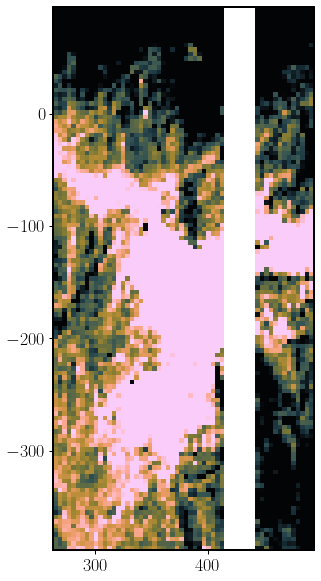

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
ax.pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, f_FeX_184_257((FeX_184_combine_rebin_10/FeX_257_combine_rebin_10).T),cmap=cmcm.batlowK,vmin=5.9,vmax=6.1)
ax.tick_params(labelsize=18)
ax.axis("scaled")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


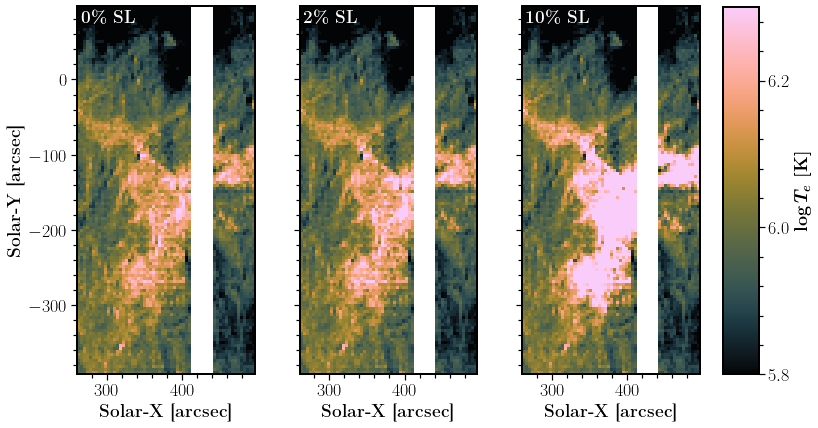

In [93]:
fig, axes = plt.subplots(1,3,figsize=(12,6))
im0 = axes[0].pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, 
f_FeX_184_257((FeX_184_combine_rebin/FeX_257_combine_rebin).T),
cmap=cmcm.batlowK,vmin=5.8,vmax=6.3,shading="auto",rasterized=True)
im1 = axes[1].pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, 
f_FeX_184_257((FeX_184_combine_rebin_2/FeX_257_combine_rebin_2).T),
cmap=cmcm.batlowK,vmin=5.8,vmax=6.3,shading="auto",rasterized=True)
im2 = axes[2].pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, 
f_FeX_184_257((FeX_184_combine_rebin_10/FeX_257_combine_rebin_10).T),
cmap=cmcm.batlowK,vmin=5.8,vmax=6.3,shading="auto",rasterized=True)

titles = [r"\textbf{0\% SL}",r"\textbf{2\% SL}",r"\textbf{10\% SL}"]
imgs = [im0,im1,im2]
for ii, ax_ in enumerate(axes):
    if (ii != 0):
        ax_.yaxis.set_ticklabels([])
    if (ii == 0):
        ax_.set_ylabel(r"\textbf{Solar-Y [arcsec]}",fontsize=18)

    #plt.colorbar(imgs[ii],ax=ax_,location="top",fraction=0.7)   
    ax_.axis("scaled")
    ax_.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax_.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax_.tick_params(which="major",width=1.2,length=6)
    ax_.tick_params(which="minor",width=1.2,length=4)
    ax_.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=18)       
    ax_.text(0.02,0.99,titles[ii],fontsize=18,color="white",transform=ax_.transAxes,ha="left",va="top")       
    ax_.tick_params(labelsize=18)

clb_ax = inset_axes(axes[2],width="20%",height= "100%",
                bbox_to_anchor=(0.5, 0.08, 1, 1),
                bbox_transform=axes[2].transAxes,
                borderpad=3)
clb = plt.colorbar(imgs[ii],pad = 0.05,orientation='vertical',ax=axes[2],cax=clb_ax)
clb_ax.yaxis.get_offset_text().set_fontsize(15)
clb_ax.yaxis.set_major_locator(ticker.MaxNLocator(3)) 
clb_ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5)) 
clb_ax.tick_params(which="major",width=1.2,length=6)
clb_ax.tick_params(which="minor",width=1.2,length=4)
# clb_ax.yaxis.tick_right()
clb_ax.tick_params(labelsize=18)
# clb_ax.xaxis.set_label_position('top') 
clb_ax.set_ylabel(r"$\boldsymbol{\log T_e\ \mathrm{[K]}}$",fontsize=18)
plt.subplots_adjust(bottom = 0.12,left=0.12,top=0.97,right=0.85)
plt.savefig(fname="../figs/temp_FeX.pdf",format="pdf")




/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


(262.7, 494.7, -389.0, 95.0)

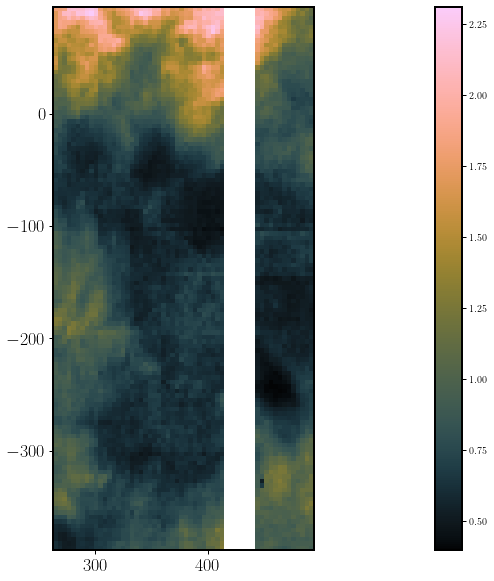

In [45]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.pcolormesh(xcoord_comb_rebin, ycoord_comb_rebin, (FeIX_191_combine_rebin/FeIX_197_combine_rebin).T,cmap=cmcm.batlowK)
plt.colorbar(im)
ax.tick_params(labelsize=18)
ax.axis("scaled")

In [46]:
def eit_plot(filename,ax,cmap,xlim,ylim,min_percent=5,max_percent=99.9):
    with fits.open(filename) as hdul:
        img = hdul[0].data
        hdr = hdul[0].header

        xcen = hdr["CRPIX1"]
        ycen = hdr["CRPIX2"]
        nx = hdr["NAXIS1"]
        ny = hdr["NAXIS2"]
        delta_x = hdr["CDELT1"]
        delta_y = hdr["CDELT2"]
        wvl = hdr["WAVELNTH"]
        date_obs = hdr["DATE-OBS"]
        
        xcoord = np.linspace(-xcen*delta_x,(nx-xcen)*delta_x,nx)
        ycoord = np.linspace(-ycen*delta_y,(ny-ycen)*delta_y,ny)
        #print(hdr)

        img_mask = np.copy(img)
        img_mask[img_mask < 0] = np.nan
        vmin = np.nanpercentile(img_mask,min_percent)
        vmax = np.nanpercentile(img_mask,max_percent)
        norm=colors.LogNorm(vmin=vmin, vmax=vmax)
        ax.pcolormesh(xcoord,ycoord,img_mask,cmap=cmap,
        norm=colors.LogNorm(vmin=vmin, vmax=vmax),rasterized=True,
        shading="auto")

        ax.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=18)
        ax.set_ylabel(r"\textbf{Solar-Y [arcsec]}",fontsize=18)
        ax.text(0.98,0.97,r"\textbf{"+date_obs[:-7]+r"}",ha = 'right',va = 'center',
         color = 'white',fontsize = 18,linespacing=1.5,transform=ax.transAxes)
        ax.text(0.02,0.97,r"\textbf{EIT "+str(wvl)+r" \mbox{\AA}}",ha = 'left',va = 'center',
         color = 'white',fontsize = 18,linespacing=1.5,transform=ax.transAxes)
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
        ax.tick_params(labelsize=18)
        ax.tick_params(which="major",width=1.2,length=6)
        ax.tick_params(which="minor",width=1.2,length=4)
        ax.axis("scaled")
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)

        return xcoord, ycoord, img_mask

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


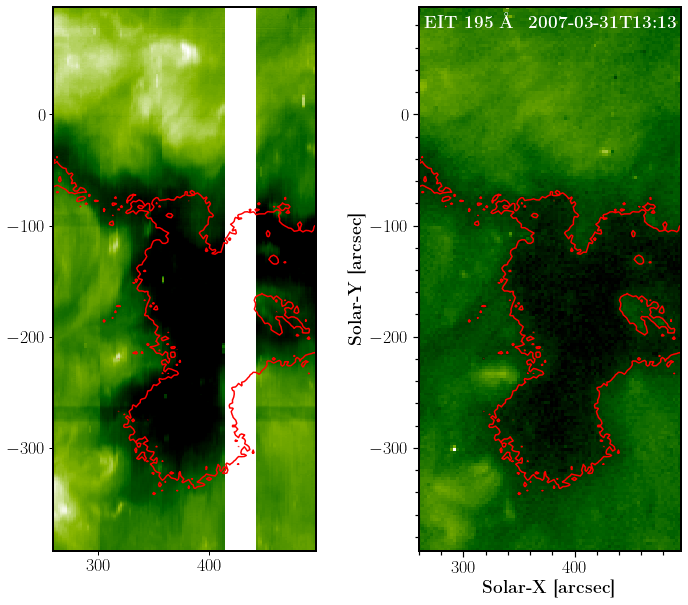

In [47]:
fig, axes = plt.subplots(1,2,figsize=(12,10))
eit_195_al1_tck = interpolate.splrep(eit_195_Aeff_list["wvl"].values,
                                     eit_195_Aeff_list["Aeff"].values, s=0)

eit_195_eis_Aeff = interpolate.splev(eis_wvl[390:2048], eit_195_al1_tck, der=0)

EIT_195_combine_map = np.sum(eis_img_combine_corp[:,:,390:2048]*eit_195_eis_Aeff,axis=2)
axes[0].pcolormesh(xcoord_comb, ycoord_comb, np.log10(EIT_195_combine_map.T),cmap=eit_195_cm)
axes[0].tick_params(labelsize=18)
axes[0].axis("scaled")

eit_195_filename = "../src/eit/level1/eit_l1_20070331_131336.fits"
eit_195_xcoord, eit_195_ycoord, eit_195_img = eit_plot(eit_195_filename,axes[1],cmap=eit_195_cm,xlim=axes[0].get_xlim(),ylim=axes[0].get_ylim())

for ax_ in axes:
    ax_.contour(eit_195_xcoord,eit_195_ycoord,eit_195_img,
                levels=[5],colors='red')


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


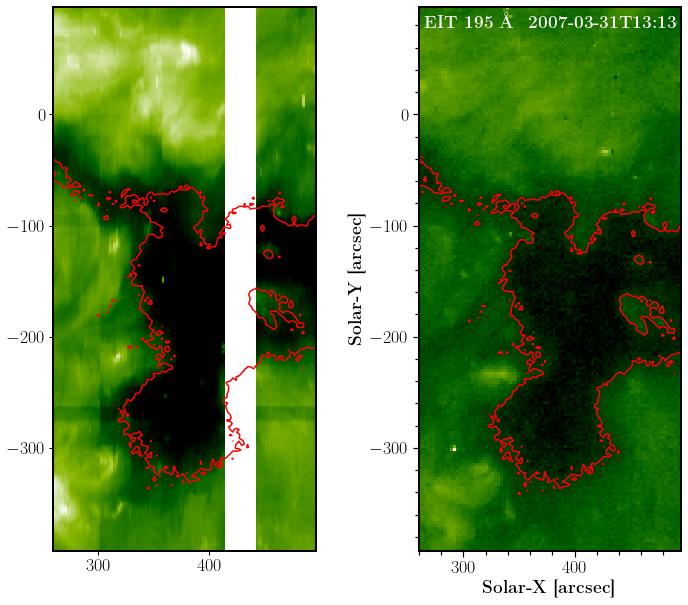

In [48]:
fig, axes = plt.subplots(1,2,figsize=(12,10))
axes[0].pcolormesh(xcoord_comb, ycoord_comb, np.log10(EIT_195_combine_map.T),cmap=eit_195_cm)
axes[0].tick_params(labelsize=18)
axes[0].axis("scaled")

eit_195_filename = "../src/eit/level1/eit_l1_20070331_131336.fits"
eit_195_xcoord, eit_195_ycoord, eit_195_img = eit_plot(eit_195_filename,axes[1],cmap=eit_195_cm,xlim=axes[0].get_xlim(),ylim=axes[0].get_ylim())

axes[0].contour(eit_195_xcoord-5,eit_195_ycoord+5,eit_195_img,
            levels=[5],colors='red')

axes[1].contour(eit_195_xcoord,eit_195_ycoord,eit_195_img,
            levels=[5],colors='red')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


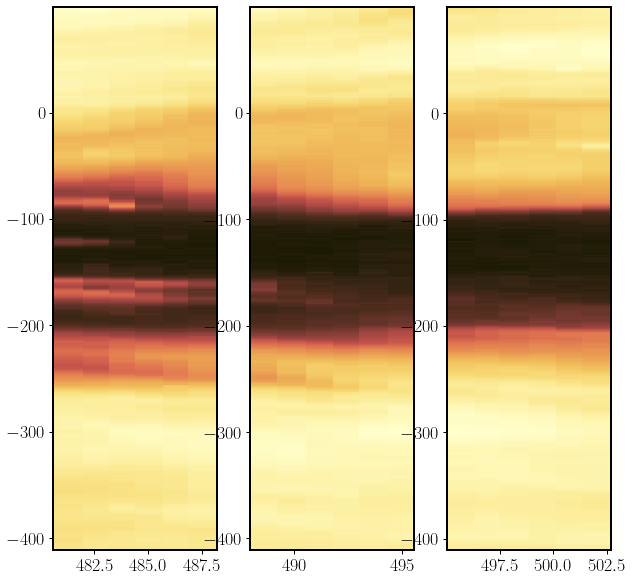

In [49]:
fig, axes = plt.subplots(1,3,figsize=(10,10))
for ii, eis_save in enumerate(eis_saves[:3]):
    eis_data = eis_save["new_data_offset"]
    eis_err = eis_save["new_err_offset"]
    eis_wvl = eis_save["wvl"]
    eis_xcoord = eis_save["xpos"]
    eis_ycoord = eis_save["ypos"]
    FeXII_195_int_map = np.sum(eis_data[:,2:514,FeXII_195_slice[0]:FeXII_195_slice[1]],axis=2)
    FeXII_186_int_map = np.sum(eis_data[:,2:514,FeXII_186_slice[0]:FeXII_186_slice[1]],axis=2)

    axes[2-ii].pcolormesh(eis_xcoord,eis_ycoord,np.log10(FeXII_195_int_map.T),cmap=cmcm.lajolla_r)
    axes[2-ii].tick_params(labelsize=18)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


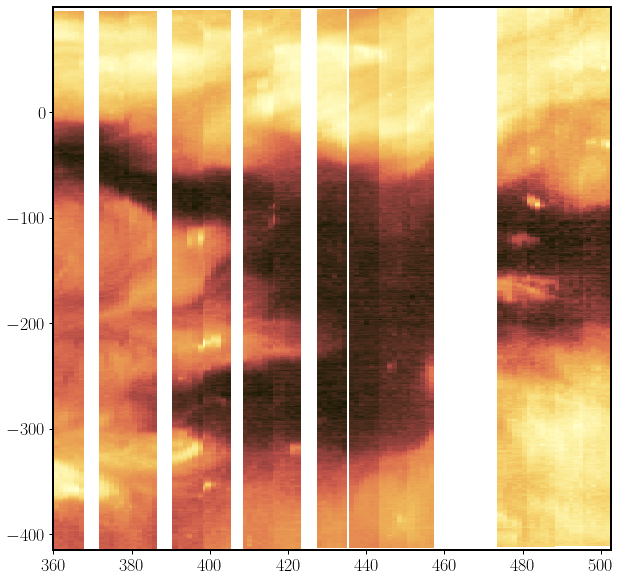

In [50]:
fig, ax = plt.subplots(figsize=(10,10))
FeXII_195_slice = (1283,1300)
FeXII_186_slice = (914,930)
for ii, eis_save in enumerate(eis_saves):
    eis_data = eis_save["new_data_offset"]
    eis_err = eis_save["new_err_offset"]
    eis_wvl = eis_save["wvl"]
    eis_xcoord = eis_save["xpos"]
    eis_ycoord = eis_save["ypos"]
    FeXII_195_int_map = np.sum(eis_data[:,2:514,FeXII_195_slice[0]:FeXII_195_slice[1]],axis=2)
    FeXII_186_int_map = np.sum(eis_data[:,2:514,FeXII_186_slice[0]:FeXII_186_slice[1]],axis=2)

    ax.pcolormesh(eis_xcoord,eis_ycoord,np.log10(FeXII_186_int_map.T),cmap=cmcm.lajolla_r)
    ax.tick_params(labelsize=18)
    #ax.axis("scaled")


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


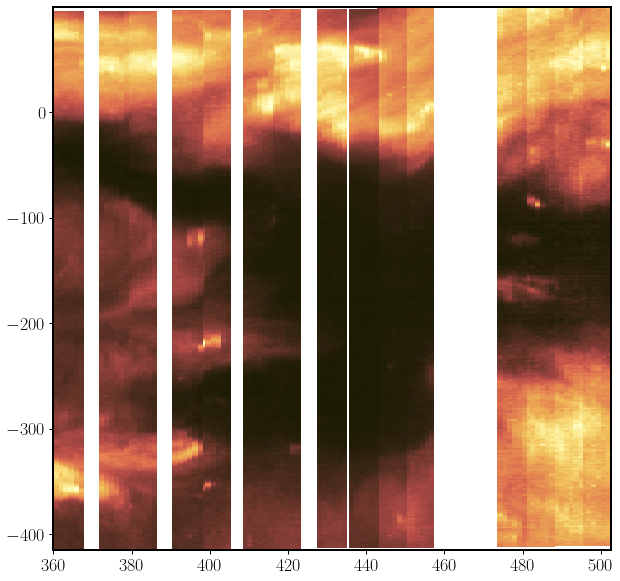

In [51]:
fig, ax = plt.subplots(figsize=(10,10))
FeXII_195_slice = (1283,1300)
FeXII_186_slice = (914,930)
for ii, eis_save in enumerate(eis_saves):
    eis_data = eis_save["new_data_offset"]
    eis_err = eis_save["new_err_offset"]
    eis_wvl = eis_save["wvl"]
    eis_xcoord = eis_save["xpos"]
    eis_ycoord = eis_save["ypos"]
    FeXII_195_int_map = np.sum(eis_data[:,2:514,FeXII_195_slice[0]:FeXII_195_slice[1]],axis=2)
    FeXII_186_int_map = np.sum(eis_data[:,2:514,FeXII_186_slice[0]:FeXII_186_slice[1]],axis=2)

    ax.pcolormesh(eis_xcoord,eis_ycoord,FeXII_186_int_map.T,cmap=cmcm.lajolla_r)
    ax.tick_params(labelsize=18)
    #ax.axis("scaled")
